ДЗ - в рамках ранее выполненной работы по обработке данных, выполнить все работы 
с пандас дата фреймом через SQL запросы. 
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать 
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)


In [1]:
import pandas as pd
import numpy as np
import re
import sqlite3
import mysql.connector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

Загружаем данные из csv файла.

In [2]:
df = pd.read_csv('credit_train.csv',on_bad_lines='skip', encoding='windows-1251', delimiter=';')

In [3]:
con = sqlite3.connect('db') #соединяемся с виртуальной базой db 

In [4]:
# Определяем функцию для удаления символов по регулярному выражению
def regexp_replace(value, pattern, replacement):
    if value is None:
        return None
    return re.sub(pattern, replacement, value)

con.create_function("REGEXP_REPLACE", 3, regexp_replace)

In [5]:
# Преобразуем в SQL
df.to_sql('credit_train',con,index=False,if_exists='replace')

170746

In [6]:
# Функция для выполения sql запросов
def select(sql):
  return pd.read_sql(sql,con)

In [7]:
select('''SELECT * FROM credit_train AS t''')

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,None,UMN,59998,10,1.6.24,None,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889,6,1.1.24,None,None,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728,12,1.1.24,None,None,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,None,SPC,"12009,09",12,1.1.24,None,None,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,None,SPC,None,10,1.1.24,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867,12,1.1.24,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,17640,6,1.6.24,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,"27556,47",10,1.1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189,12,1.1.24,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


Необходимо подготовить данные.
1. Исключим из столбца living_region небуквенные значения, а также слова, не несущие смысловой нагрузки и мешающие дальнейшему анализу.

In [ ]:
cursor = con.cursor()
cursor.execute('''
    UPDATE credit_train
    SET living_region = REGEXP_REPLACE(living_region, '[^а-яА-Яa-zA-Z\s]', '')
''')

con.commit()

In [9]:
df = select('''SELECT * FROM credit_train AS t''')

In [10]:
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,None,UMN,59998,10,1.6.24,None,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889,6,1.1.24,None,None,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728,12,1.1.24,None,None,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,None,SPC,"12009,09",12,1.1.24,None,None,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,None,SPC,None,10,1.1.24,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867,12,1.1.24,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,17640,6,1.6.24,"0,573287",SCH,САНКТПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,"27556,47",10,1.1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189,12,1.1.24,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


In [11]:
trash_words = ['РЕСП','РЕСП.','РЕСПУБЛИКА', 'САХА', 'ОБЛ','АОБЛ', 'АВТОНОМНЫЙ ОКРУГ','ЮГРА', 'ЧУВАШИЯ', 'ФЕДЕРАЛЬНЫЙ ОКРУГ', 'АО', 'ОБЛАСТЬ', 'КРАЙ', 'Г', 'Ю', 'СЕВ.', 'СЕВЕРНАЯ', 'АЛАНИЯ', ' ']

In [12]:
# Определяем функцию для удаления слов
def remove_words(value, words):
    if value is None:
        return None
    # Создаем регулярное выражение для удаления всех слов
    pattern = r'\b(' + '|'.join(map(re.escape, words)) + r')\b'
    return re.sub(pattern, '', value).strip()

con.create_function("REMOVE_WORDS", 1, lambda value: remove_words(value, trash_words))

In [13]:
cursor.execute('''
    UPDATE credit_train
    SET living_region  = REMOVE_WORDS(living_region);
''')

# Сохраняем изменения
con.commit()

In [14]:
df = select('''SELECT * FROM credit_train AS t''')

In [15]:
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,None,UMN,59998,10,1.6.24,None,GRD,КРАСНОДАРСКИЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,10889,6,1.1.24,None,None,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,10728,12,1.1.24,None,None,САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,None,SPC,"12009,09",12,1.1.24,None,None,ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,None,SPC,None,10,1.1.24,"0,421385",SCH,ЧЕЛЯБИНСКАЯ,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27.0,UNM,SPC,64867,12,1.1.24,"0,535257",GRD,ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24.0,MAR,SPC,17640,6,1.6.24,"0,573287",SCH,САНКТПЕТЕРБУРГ,30000.0,1.0,0.0,0
170743,170744,F,31.0,UNM,SPC,"27556,47",10,1.1.32,"0,416098",GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0
170744,170745,F,53.0,DIV,PNA,6189,12,1.1.24,"0,482595",SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0


Также удаляем строки с неорректными значениями '1.0' в поле tariff_id.

In [16]:
cursor.execute('''
    DELETE FROM credit_train
WHERE tariff_id = '1.0';
''')

# Сохраняем изменения
con.commit()

In [17]:
df = select('''SELECT * FROM credit_train AS t''')

2. Оценим количество пропусков в данных.

In [18]:
# Получение названий столбцов
cursor.execute(f"PRAGMA table_info(credit_train);")
columns = [row[1] for row in cursor.fetchall()]

In [19]:
# Получение общего количества строк в таблице
cursor.execute(f"SELECT COUNT(*) FROM credit_train;")
total_rows = cursor.fetchone()[0]

In [20]:
# Создание таблицы для хранения результата
cursor.execute("""
    CREATE TABLE IF NOT EXISTS missing_values (
        column_name TEXT,
        missing_count INTEGER,
        missing_percentage REAL
    );
""")

In [21]:
# Подсчет пропусков для каждого столбца и вставка результатов
for column in columns:
    cursor.execute(f"""
        INSERT INTO missing_values (column_name, missing_count, missing_percentage)
        SELECT 
            '{column}' AS column_name, 
            COUNT(*) - COUNT({column}) AS missing_count,
            ((COUNT(*) - COUNT({column})) * 100.0 / ?) AS missing_percentage
        FROM credit_train;
    """, (total_rows,))


con.commit()

In [22]:
df_none = select('''SELECT * FROM missing_values AS t''')

In [23]:
df_none

,column_name,missing_count,missing_percentage
0,client_id,0,0.000000
1,gender,0,0.000000
2,age,3,0.001780
3,marital_status,3,0.001780
4,job_position,0,0.000000
...,...,...,...
70,living_region,192,0.113946
71,monthly_income,5,0.002967
72,credit_count,9167,5.440324
73,overdue_credit_count,9167,5.440324


Наибольшее количество пропусков  - в столбцах credit_count и overdue_credit_count. Заменим их на медианные значения столбцов. Остальные строки с пропусками удалим, так как процент данных с пропусками небольшой.

In [24]:
median_value_credit_count = df['credit_count'].median()
median_value_overdue_credit_count = df['overdue_credit_count'].median()

con.execute(f"""
    UPDATE credit_train
    SET credit_count = ?
    WHERE credit_count IS NULL;
""", (median_value_credit_count,))
con.commit()

con.execute(f"""
    UPDATE credit_train
    SET overdue_credit_count = ?
    WHERE overdue_credit_count IS NULL;
""", (median_value_overdue_credit_count,))
con.commit()

# Создание условия для удаления строк с NULL в любом столбце
condition = " OR ".join([f"{col} IS NULL" for col in columns])
cursor.execute(f"DELETE FROM credit_train WHERE {condition};")
con.commit()

#df['credit_count'] = df['credit_count'].fillna(df['credit_count'].median())
#df['overdue_credit_count'] = df['overdue_credit_count'].fillna(df['overdue_credit_count'].median())
#df = df.dropna()

In [25]:
df = select('''SELECT * FROM credit_train AS t''')

In [26]:
df.describe()

,client_id,age,credit_month,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000,168298.000000
mean,85397.665100,36.486880,10.927569,40171.177738,2.100887,0.043577,0.177643
std,49287.259671,10.542829,3.449106,25067.884952,1.729175,0.206008,0.382213
min,8.000000,18.000000,3.000000,5000.000000,0.000000,0.000000,0.000000
25%,42701.250000,28.000000,10.000000,25000.000000,1.000000,0.000000,0.000000
50%,85406.500000,34.000000,10.000000,35000.000000,2.000000,0.000000,0.000000
75%,128080.750000,43.000000,12.000000,50000.000000,3.000000,0.000000,0.000000
max,170746.000000,71.000000,36.000000,950000.000000,21.000000,3.000000,1.000000


In [27]:
df.dtypes

client_id                 int64
gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum               object
credit_month              int64
tariff_id                object
score_shk                object
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
open_account_flg          int64
dtype: object

Оценим количество значений living_region

In [28]:
count_regions = select('''SELECT living_region, COUNT(*) AS count
FROM credit_train
GROUP BY living_region
ORDER BY count DESC;'''
)

In [29]:
count_regions

,living_region,count
0,МОСКОВСКАЯ,12755
1,МОСКВА,9146
2,КРАСНОДАРСКИЙ,8306
3,САНКТПЕТЕРБУРГ,8049
4,ТАТАРСТАН,7665
...,...,...
103,ДАЛЬНИЙВОСТОК,1
104,ГУСЬХРУСТАЛЬНЫЙРН,1
105,ГОДИНЦОВОМОСКОВСКАЯ,1
106,ГМОСКВА,1


Построим график частоты встречаемости различных регионов

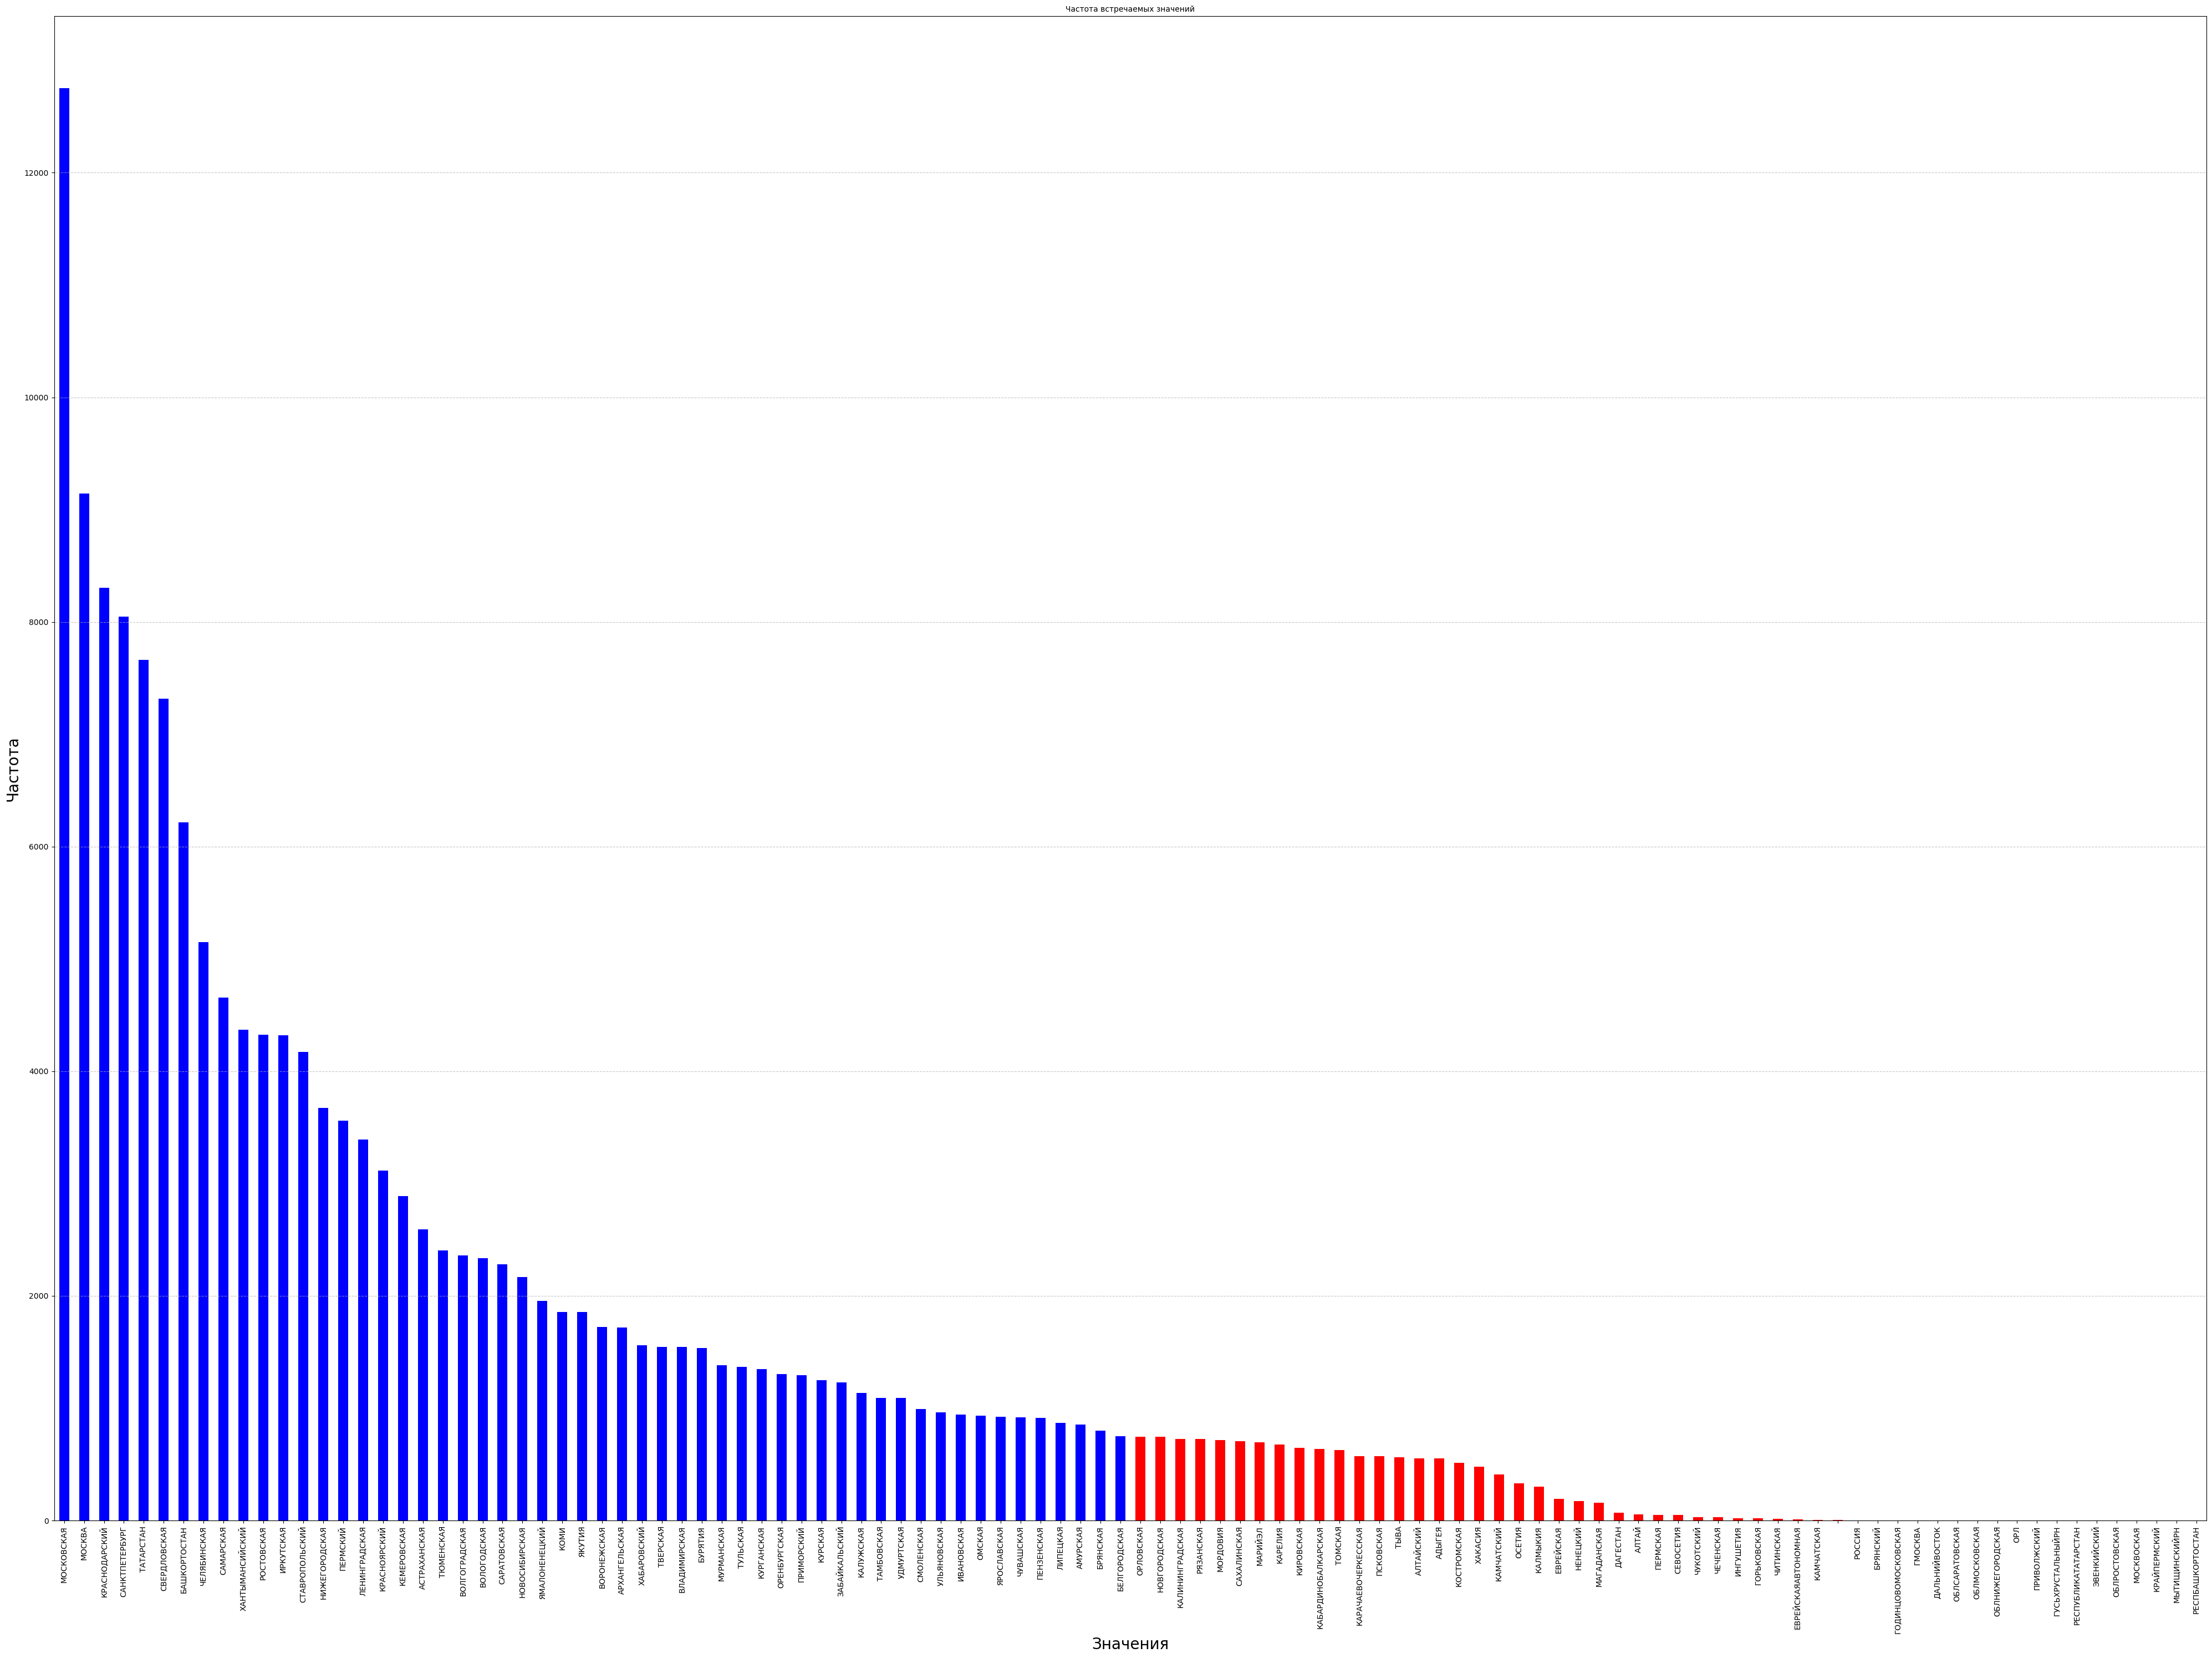

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

value_counts = df['living_region'].value_counts()

color = ['red' if value < value_counts.median() else 'blue' for value in value_counts]
value_counts.plot(kind='bar', color=color, figsize=(40, 30))

# Настройка графика
plt.title('Частота встречаемых значений', fontsize=10)
plt.xlabel('Значения', fontsize=20)
plt.ylabel('Частота', fontsize=20)
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
# Отображение графика
plt.show()

In [31]:
print("Медианное значение", value_counts.median())

Медианное значение 748.0


Регионы, количество которых в выборке меньше 748, сгруппируем в Другие.

In [32]:

# Установим минимальный порог для частоты категории
threshold = value_counts.median()  # Группируем категории, количество которых в выборке ниже медианного значения
city_counts = df['living_region'].value_counts()

# Заменяем редкие города на "Другие"
df['living_region'] = df['living_region'].apply(lambda x: x if city_counts[x] > threshold else 'Другие')


In [33]:
cursor.execute(f"""
    SELECT living_region
    FROM credit_train
    GROUP BY living_region
    HAVING COUNT(*) >= 744;
""")

In [34]:
threshold = value_counts.median()
replacement_value = 'Другие'
# Шаг 1: Получение значений, которые нужно сохранить
cursor.execute(f"""
    SELECT living_region
    FROM credit_train
    GROUP BY living_region
    HAVING COUNT(*) >= {threshold};
""")
values_to_keep = [row[0] for row in cursor.fetchall()]

# Шаг 2: Обновление значений, которые ниже порога
cursor.execute(f"""
    UPDATE credit_train
    SET living_region = ?
    WHERE living_region NOT IN ({','.join(['?'] * len(values_to_keep))});
""", [replacement_value] + values_to_keep)

con.commit()

In [35]:
df = select('''SELECT * FROM credit_train AS t''')

In [36]:
df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,8,F,26.0,UNM,SPC,47878,10,1.1.24,"0,512525",GRD,МОСКОВСКАЯ,60000.0,3.0,0.0,0
1,10,F,32.0,UNM,SPC,26268,10,1.1.24,"0,465026",GRD,СТАВРОПОЛЬСКИЙ,39500.0,7.0,0.0,0
2,13,M,37.0,MAR,SPC,42289,10,1.6.24,"0,691609",SCH,АРХАНГЕЛЬСКАЯ,70000.0,1.0,0.0,0
3,14,M,43.0,MAR,INP,57567,10,1.1.24,"0,341164",GRD,ХАНТЫМАНСИЙСКИЙ,60000.0,7.0,0.0,0
4,16,M,34.0,MAR,SPC,13209,10,1.1.24,"0,498255",SCH,ПЕРМСКИЙ,34000.0,2.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168293,170742,F,27.0,UNM,SPC,64867,12,1.1.24,"0,535257",GRD,ТАТАРСТАН,40000.0,6.0,0.0,0
168294,170743,F,24.0,MAR,SPC,17640,6,1.6.24,"0,573287",SCH,САНКТПЕТЕРБУРГ,30000.0,1.0,0.0,0
168295,170744,F,31.0,UNM,SPC,"27556,47",10,1.1.32,"0,416098",GRD,ПРИМОРСКИЙ,40000.0,1.0,0.0,0
168296,170745,F,53.0,DIV,PNA,6189,12,1.1.24,"0,482595",SCH,ПЕНЗЕНСКАЯ,31000.0,2.0,0.0,0


Добавим дополнительные переменные.
1. Средний ежемесячный платёж
2. Отношение суммы кредита к ежемесячному доходу
3. Отношение ежемесячного дохода к количеству кредитов
4. Возрастная категория
5. Категория по доходу

In [37]:
sql = '''
SELECT 
    t.*, 
    t.credit_sum / t.credit_month AS monthly_payment,
    t.credit_sum / t.monthly_income AS credit_income_ratio,
    CASE WHEN t.credit_count > 0 THEN t.monthly_income / t.credit_count ELSE NULL END AS income_per_credit,
    CASE
        WHEN t.age < 30 THEN 'young'
        WHEN t.age >= 30 AND t.age <= 50 THEN 'middle'
        ELSE 'old'
    END AS age_category,
    CASE 
        WHEN t.monthly_income > 50000 THEN 'high' 
        ELSE 'low' 
    END AS income_score
FROM credit_train t;'''

In [38]:
df = select(sql)

In [39]:
df.dtypes

client_id                 int64
gender                   object
age                     float64
marital_status           object
job_position             object
credit_sum               object
credit_month              int64
tariff_id                object
score_shk                object
education                object
living_region            object
monthly_income          float64
credit_count            float64
overdue_credit_count    float64
open_account_flg          int64
monthly_payment           int64
credit_income_ratio     float64
income_per_credit       float64
age_category             object
income_score             object
dtype: object

Выполниим преобразование типов
В рамках задания преобразование типов удобнее выполнить средствами pandas, так как SQLite не поддерживает смену типов данных в текущей таблице, что приведет к необходиомсти создания новой таблицы и копирования данных.

In [40]:
df['tariff_id'] = pd.to_datetime(df['tariff_id'], dayfirst=True, format="%d.%m.%y" ) # Приводим tariff_id к формату даты

In [41]:
df['credit_sum'] = df['credit_sum'].str.replace(',', '.', regex=False)
df['credit_sum'] = df['credit_sum'].astype(float)

In [42]:
df['score_shk'] = df['score_shk'].str.replace(',', '.', regex=False)
df['score_shk'] = df['score_shk'].astype(float)

open_account_flg приводим к типу bool, так как это флаг.

In [43]:
df['open_account_flg'] = df['open_account_flg'].astype(bool)

Дальнейшие действия выполнялись с использованием Pandas.

Выполним преобразование категориальных столбцов с помощью OneHotEncoder

In [65]:

categorical_features = ['gender', 'marital_status', 'job_position', 'education','living_region', 'age_category', 'income_score']
numerical_features = ['client_id', 'age', 'credit_sum', 'credit_month','tariff_id', 'score_shk', 'monthly_income','credit_count','overdue_credit_count','open_account_flg', 'credit_income_ratio','monthly_payment', 'income_per_credit']
categorical_transformer = OneHotEncoder(sparse_output = False)
original_dtypes = df.dtypes.to_dict()
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

transformed_data = preprocessor.fit_transform(df)


In [66]:
transformed_data.shape

(168298, 103)

И объединим столбцы обратно в DataFrame, назначив категориальным столбцам тип category.

In [67]:
categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_columns = list(categorical_columns) + numerical_features
transformed_df = pd.DataFrame(transformed_data, columns=all_columns)
for col in all_columns:
    if col in original_dtypes:
        transformed_df[col] = transformed_df[col].astype(original_dtypes[col])
    else:
         transformed_df[col]= transformed_df[col].astype('category')
#print(transformed_df)

Оценим выбросы в данных, построив "ящики с усами" и гистограммы данных.

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

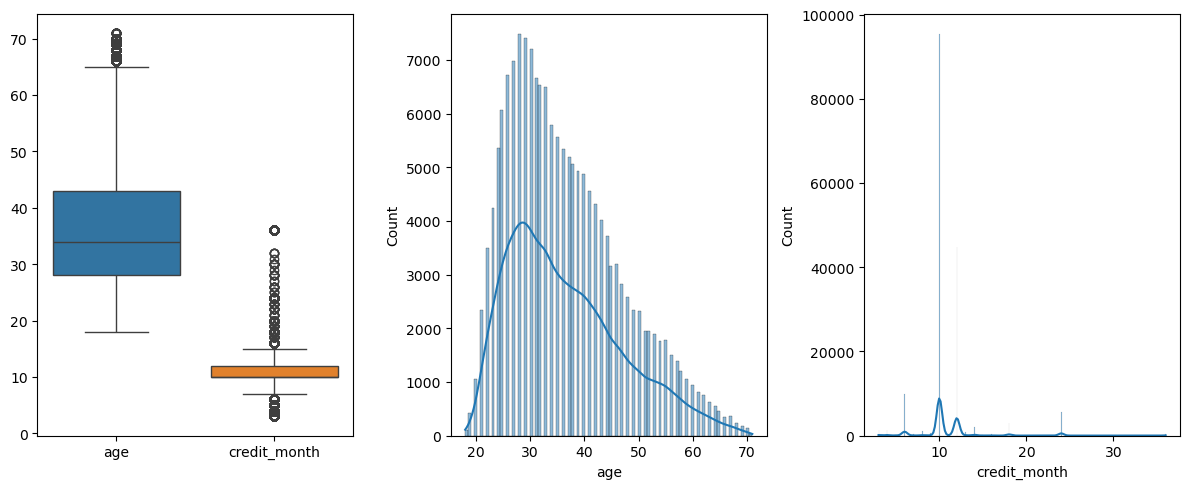

In [48]:
selected_columns = ["age", "credit_month"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 строка, 2 столбца
sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['age'],kde=1,  ax = axes[1])
sns_plot1 = sns.histplot(transformed_df['credit_month'],kde=1,  ax = axes[2])
plt.tight_layout()
plt.show()

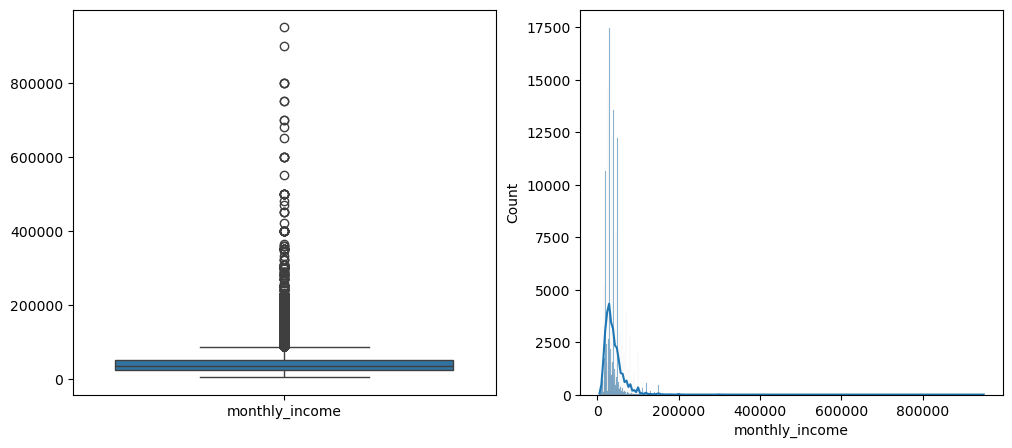

In [49]:
selected_columns = ["monthly_income"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['monthly_income'],kde=1,  ax = axes[1])


plt.show()

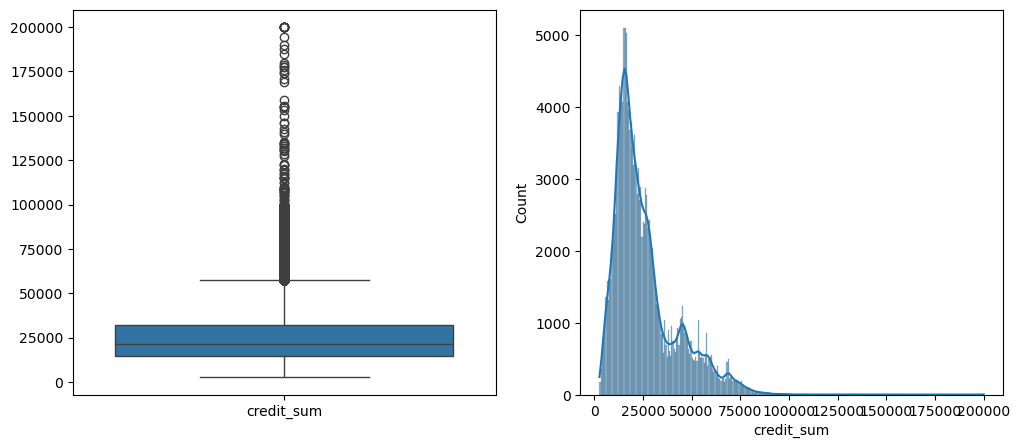

In [50]:
selected_columns = ["credit_sum"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['credit_sum'],kde=1,  ax = axes[1])
plt.show()

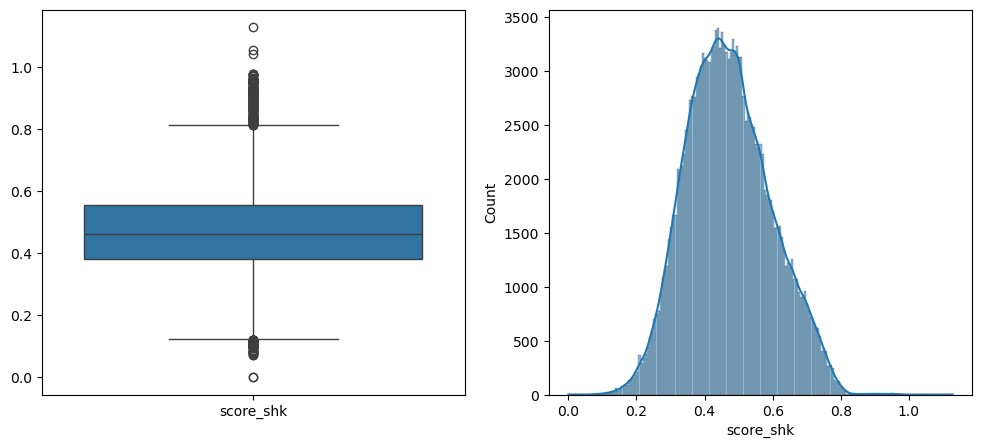

In [51]:
selected_columns = ["score_shk"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца
box = sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['score_shk'],kde=1,  ax = axes[1])
plt.show()

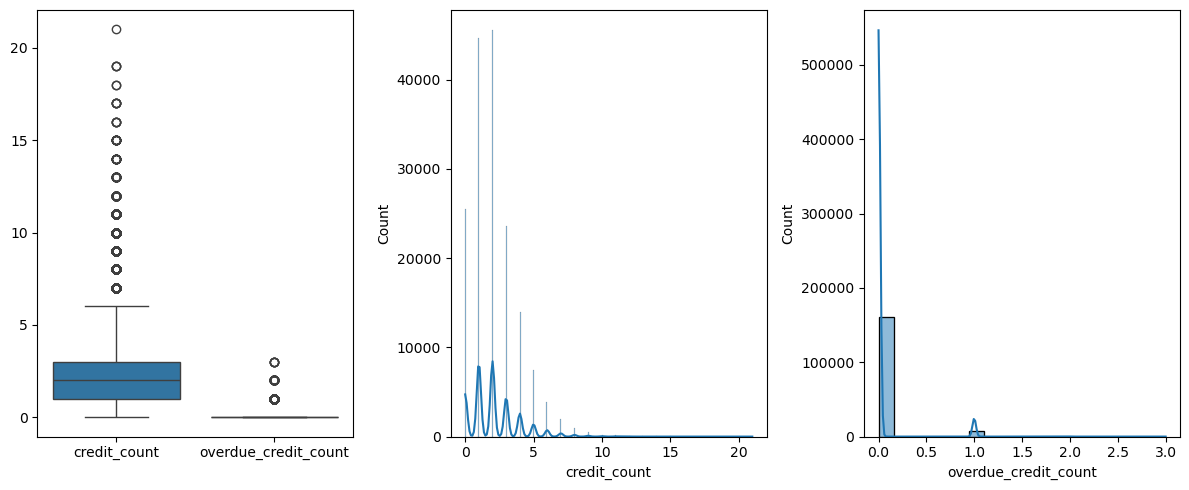

In [52]:
selected_columns = ["credit_count", "overdue_credit_count"]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 строка, 2 столбца
sns.boxplot(data=transformed_df[selected_columns], ax = axes[0])
sns_plot = sns.histplot(transformed_df['credit_count'],kde=1,  ax = axes[1])
sns_plot1 = sns.histplot(transformed_df['overdue_credit_count'],kde=1,  ax = axes[2])
plt.tight_layout()
plt.show()

Для данных "age", "credit_month", "monthly_income", "credit_sum", "credit_count", "overdue_credit_count","score_shk"  имеет смысл удалить выбросы.
Удалим значения, которые лежат за 1 и 3 квартилями (25 и 75 %).

In [69]:

def remove_outliers(df,columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
columns = ['age', 'credit_month', 'monthly_income', 'credit_sum', 'credit_count', 'score_shk', 'overdue_credit_count']
fitered_transformed_df = remove_outliers(transformed_df, columns)
#print(df)


Построим карту корреляции.

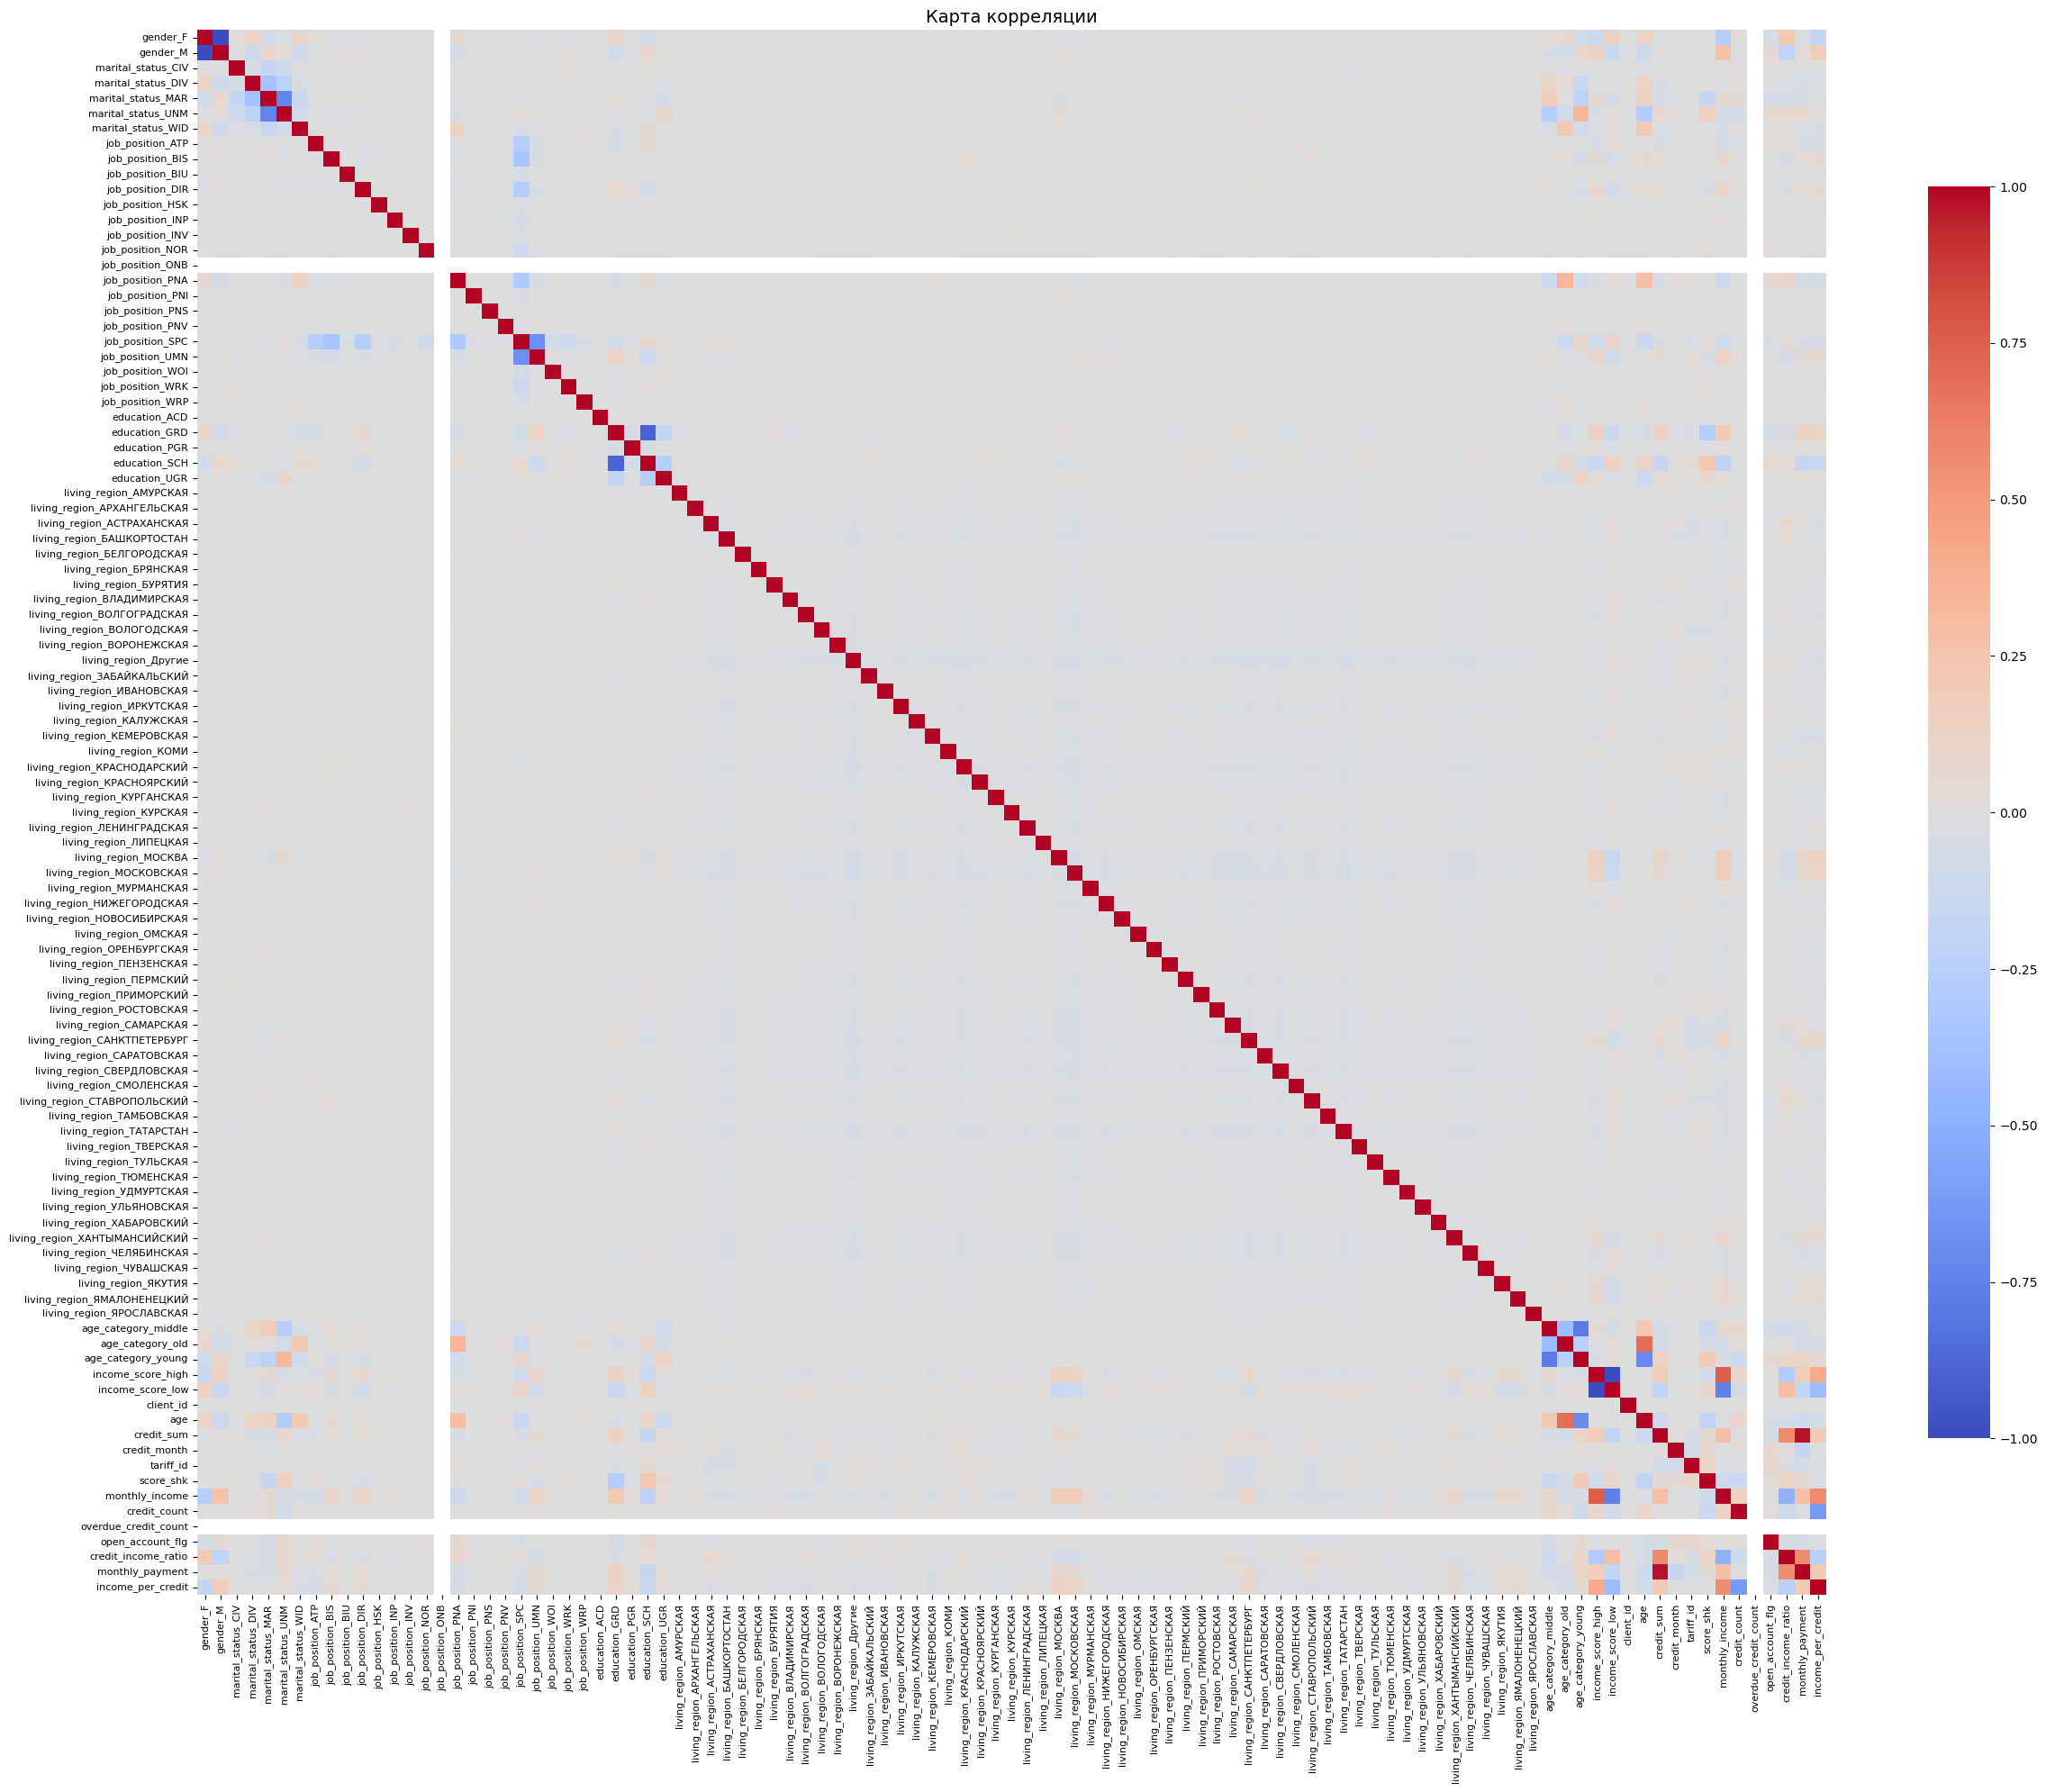

In [70]:
correlation_matrix = fitered_transformed_df.corr()

# Настраиваем размеры фигуры для лучшей читаемости
plt.figure(figsize=(25, 20))  # Размеры графика

sns.heatmap(
    correlation_matrix,
    annot=False,               # Не отображать числовые значения на ячейках
    cmap="coolwarm",           # Цветовая карта
    vmin=-1, vmax=1,           # Ограничения для значений корреляции
    cbar_kws={"shrink": 0.8}   # Уменьшение размера цветовой полосы
)


# Настраиваем подписи осей
plt.xticks(rotation=90, fontsize=8) 
plt.yticks(fontsize=8)               
plt.title("Карта корреляции", fontsize=14)  # Заголовок

plt.tight_layout()  # Подгонка элементов графика
plt.show()

Судя по карте корреляции, прямую корреляцию имеют параметры 'age' и 'job_position_PNA'.

Unmarried (не женат/ не замужем) имеет обратную корреляцию с возрастом (age).
WID (вдова/вдовец) имеет прямую корреляцию с возрастом (age).
Месячный доход (monthly_income) имеет прямую корреляцию с суммой по кредиту, а также с местом проживания (Москва, Московская область), и полом (мужской).

Корреляции, симметричные к диагонали, не имеют смысла, так как представлют взаимоисключающие понятия.
Столбцы overdue_credit_count и job_position_ONB не содержат полезных данных, их можно удалить.

In [71]:

del fitered_transformed_df['overdue_credit_count']
del fitered_transformed_df['job_position_ONB']


Проверим столбцы на нормальное распределение с помощью критерия Пирсона

In [72]:
from scipy.stats import normaltest
normal_counter = {}
for features in fitered_transformed_df.columns:
    if fitered_transformed_df[features].dtype in ['datetime64[ns]', 'bool']: # Исключим булевые типы и даты
        continue
    stat, p = normaltest(fitered_transformed_df[features])
    #print(f"Statistic: {stat}, p-value: {p}")
    if p > 0.05:
        normal_counter[features] = p
if normal_counter:
    for i in normal_counter:
        print (f"Значение {i[0]} распределено нормально, p = {i[1]}")
else:
    print ("В датасете нет нормально распределенных значений")
           


В датасете нет нормально распределенных значений


Выполним скалирование данных используя MinMaxScaler

Сделаем выборку столбцов, подлжеащих скалированию, с помощью SQL.

In [73]:
fitered_transformed_df.to_sql('fitered_transformed_table',con,index=False,if_exists='replace')

121267

In [75]:
numerical_scale_features = select('''SELECT age, credit_month, monthly_income, credit_sum, credit_count, score_shk, monthly_payment, credit_income_ratio, income_per_credit from fitered_transformed_table''')

In [76]:
numerical_scale_features

,age,credit_month,monthly_income,credit_sum,credit_count,score_shk,monthly_payment,credit_income_ratio,income_per_credit
0,26.0,10,60000.0,47878.00,3.0,0.512525,4787,0.797967,20000.000000
1,37.0,10,70000.0,42289.00,1.0,0.691609,4228,0.604129,70000.000000
2,34.0,10,34000.0,13209.00,2.0,0.498255,1320,0.388500,17000.000000
3,36.0,10,50000.0,22612.00,4.0,0.483082,2261,0.452240,12500.000000
4,54.0,12,40000.0,24990.00,6.0,0.413558,2082,0.624750,6666.666667
...,...,...,...,...,...,...,...,...,...
121262,32.0,10,25000.0,15282.00,2.0,0.514811,1528,0.611280,12500.000000
121263,24.0,12,22000.0,19818.00,1.0,0.624391,1651,0.900818,22000.000000
121264,31.0,10,40000.0,27556.47,1.0,0.416098,2755,0.688900,40000.000000
121265,53.0,12,31000.0,6189.00,2.0,0.482595,515,0.199645,15500.000000


In [77]:
from sklearn.preprocessing import MinMaxScaler

#numerical_scale_features = fitered_transformed_df
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_scale_features)

# Преобразование обратно в DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=numerical_scale_features.columns).reset_index(drop=1)

categorical_columns = [col for col in fitered_transformed_df.columns if col not in scaled_data.columns]
categorical_df = fitered_transformed_df[categorical_columns].reset_index(drop=1)
# Объединяем с категориальными признаками
result = pd.concat([scaled_data, categorical_df], axis=1)
#result.reset_index()
result = result.set_index('client_id')
#print(result)

In [78]:
result

,age,credit_month,monthly_income,credit_sum,credit_count,score_shk,monthly_payment,credit_income_ratio,income_per_credit,gender_F,...,living_region_ЯКУТИЯ,living_region_ЯМАЛОНЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,age_category_middle,age_category_old,age_category_young,income_score_high,income_score_low,tariff_id,open_account_flg
client_id,,,,,,,,,,,,,,,,,,,,,
8,-0.988118,-0.620867,1.558927,2.267526,0.773954,0.334511,2.473198,0.178355,-0.078200,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2024-01-01,False
13,0.084609,-0.620867,2.202081,1.759238,-0.618431,1.825065,1.945036,-0.306235,3.394916,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2024-06-01,False
16,-0.207953,-0.620867,-0.113271,-0.885423,0.077762,0.215738,-0.802538,-0.845300,-0.286587,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-01-01,False
17,-0.012912,-0.620867,0.915774,-0.030274,1.470147,0.089450,0.086550,-0.685952,-0.599168,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-04-01,False
18,1.742458,1.254834,0.272621,0.185992,2.862532,-0.489213,-0.082575,-0.254682,-1.004365,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2024-01-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170740,-0.402994,-0.620867,-0.692109,-0.696895,0.077762,0.353537,-0.606013,-0.288356,-0.599168,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-01-01,False
170741,-1.183159,1.254834,-0.885055,-0.284372,-0.618431,1.265595,-0.489798,0.435481,0.060724,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2024-06-01,False
170744,-0.500515,-0.620867,0.272621,0.419398,-0.618431,-0.468072,0.553297,-0.094308,1.311046,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2032-01-01,False


Для сравнения снова построим карту корреляции.

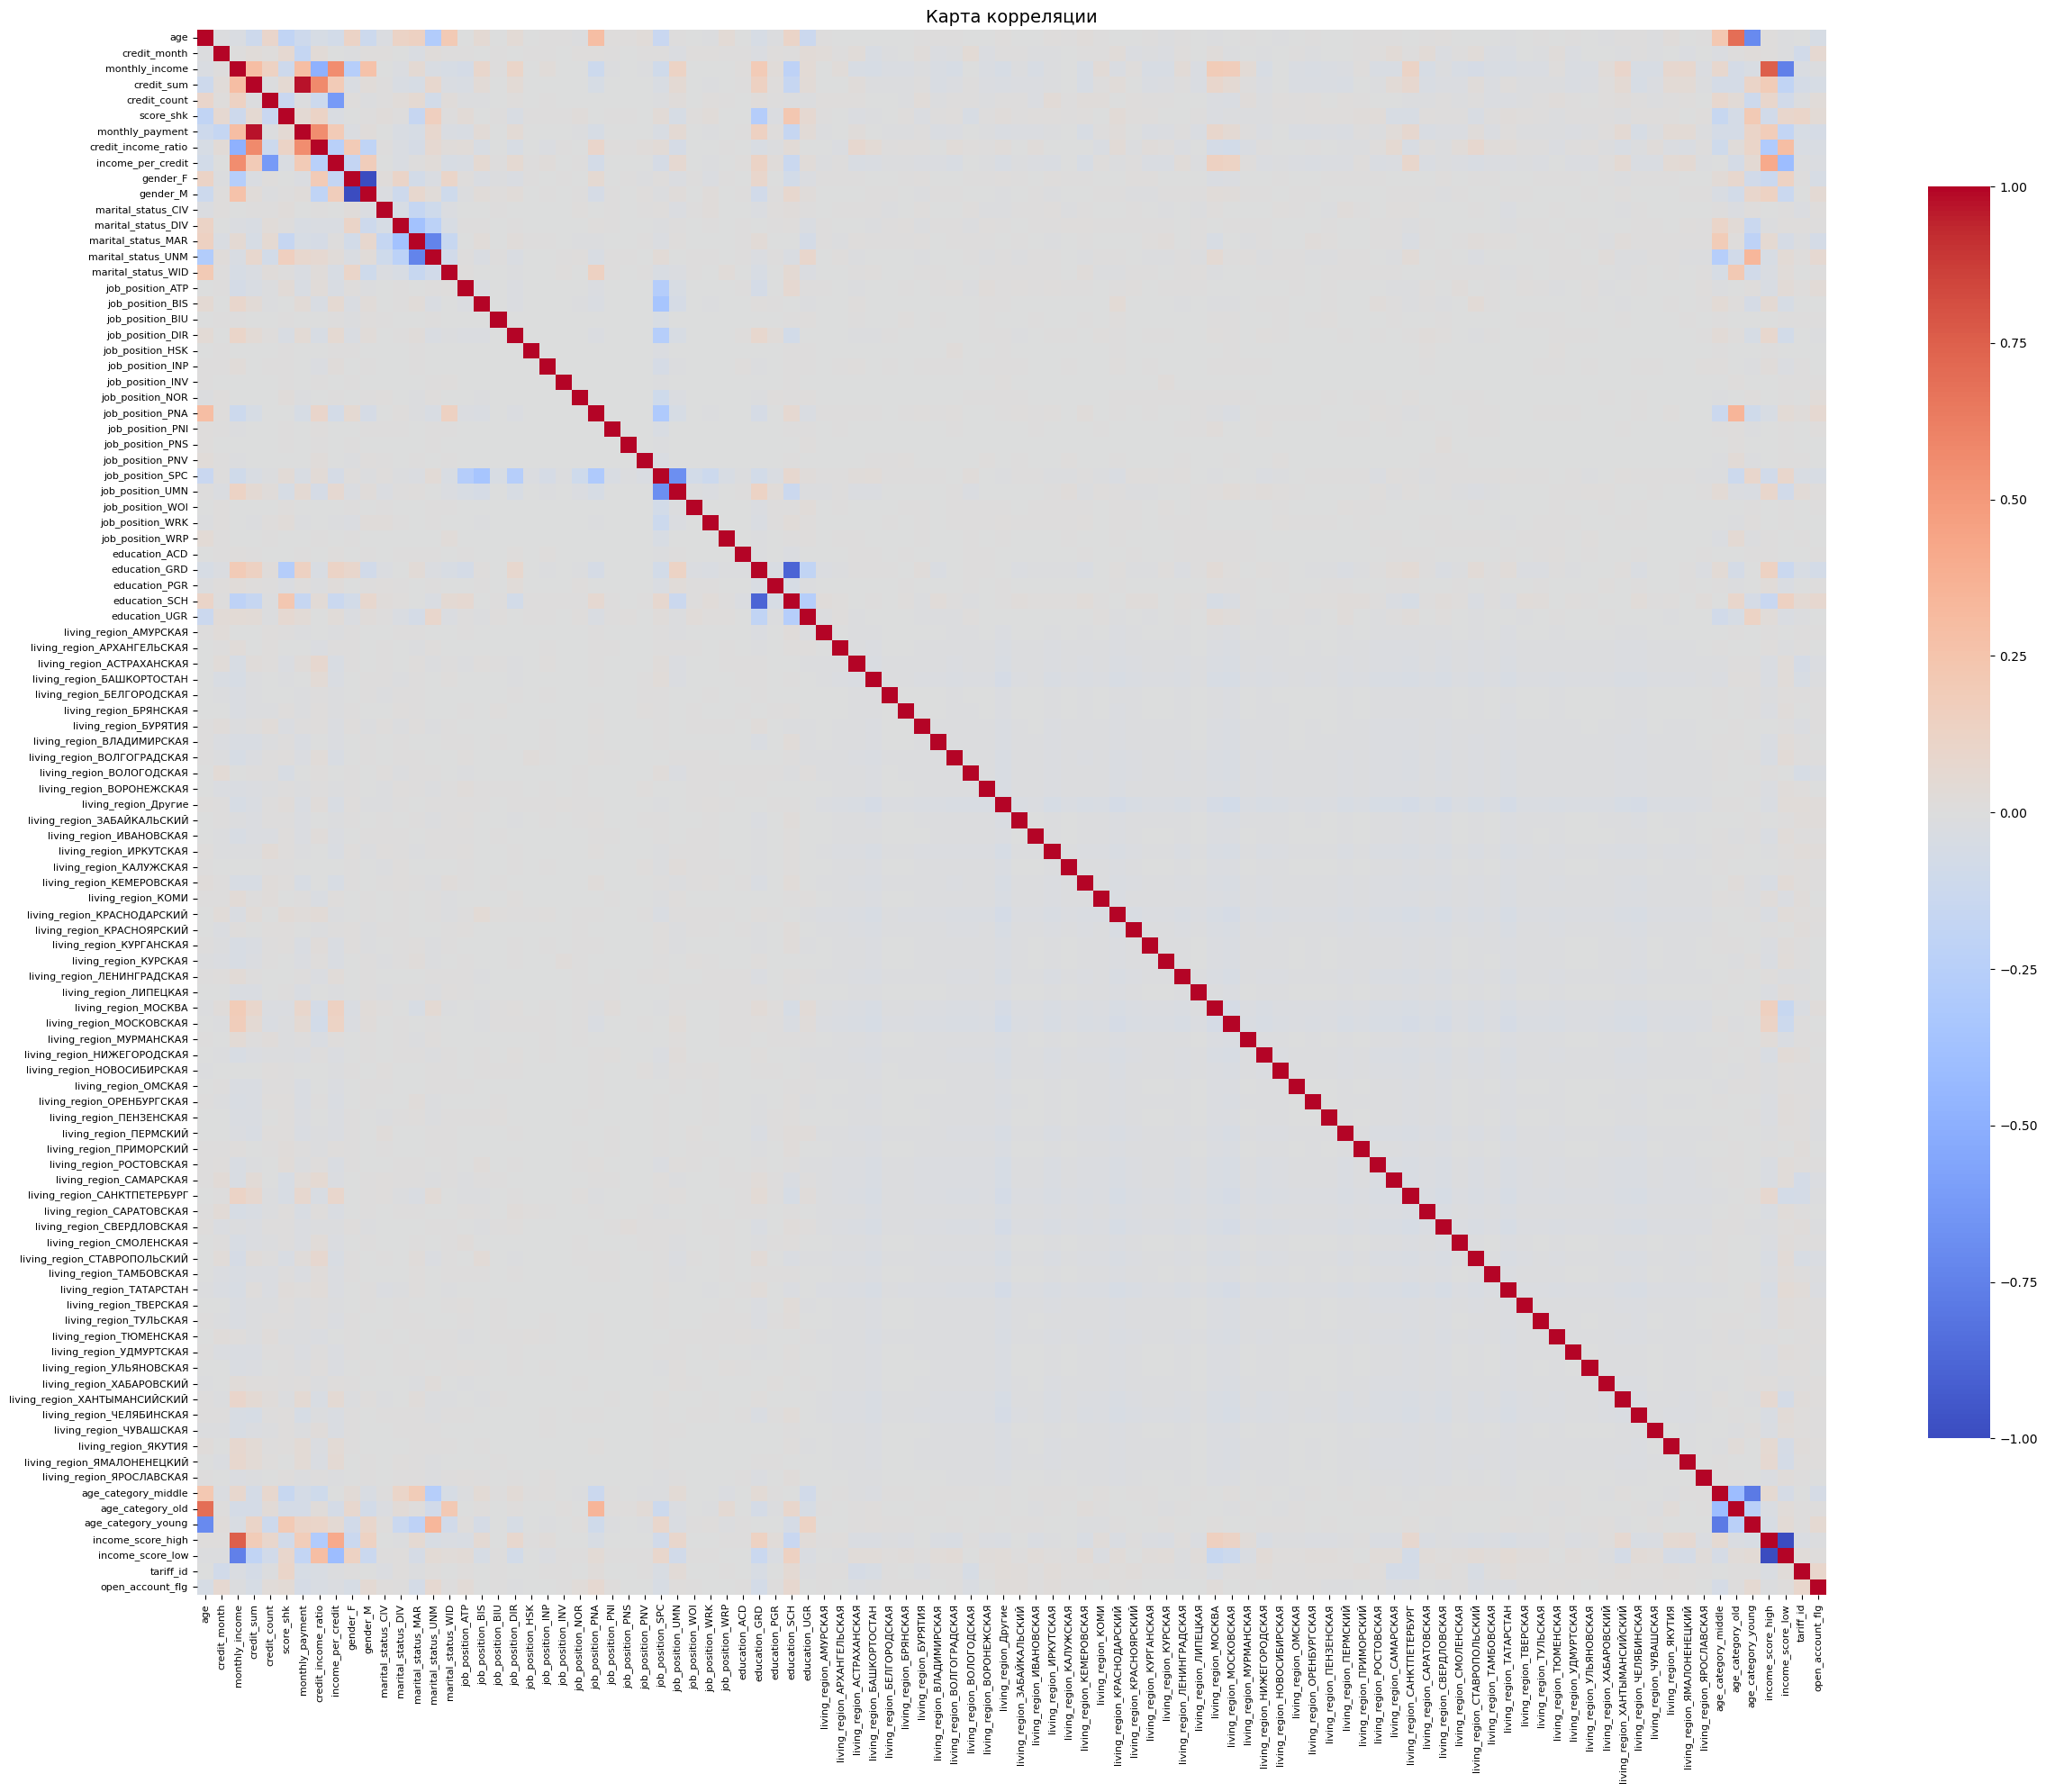

In [80]:
correlation_matrix = result.corr()

# Настраиваем размеры фигуры для лучшей читаемости
plt.figure(figsize=(25, 20))  # Размеры графика

sns.heatmap(
    correlation_matrix,
    annot=False,               # Не отображать числовые значения на ячейках
    cmap="coolwarm",           # Цветовая карта
    vmin=-1, vmax=1,           # Ограничения для значений корреляции
    cbar_kws={"shrink": 0.8}   # Уменьшение размера цветовой полосы
)


# Настраиваем подписи осей
plt.xticks(rotation=90, fontsize=8) 
plt.yticks(fontsize=8)               
plt.title("Карта корреляции", fontsize=14)  # Заголовок

plt.tight_layout()  # Подгонка элементов графика
plt.show()

Видно, что корреляция признаков до и после скалирования отличается незначительно.

Разделим данные на обучающий и тестовый датасеты с помощью train_test_split

In [82]:
from sklearn.model_selection import train_test_split

# Разделение на train и test
train_df, test_df = train_test_split(
    result,
    test_size=0.5,      # Половина данных в тестовую выборку
    random_state=42,    # Фиксация случайного разбиения для воспроизводимости
    shuffle=True        # Перемешивание перед разделением
)

print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

Размер обучающей выборки: (60633, 100)
Размер тестовой выборки: (60634, 100)


In [83]:
train_df

,age,credit_month,monthly_income,credit_sum,credit_count,score_shk,monthly_payment,credit_income_ratio,income_per_credit,gender_F,...,living_region_ЯКУТИЯ,living_region_ЯМАЛОНЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,age_category_middle,age_category_old,age_category_young,income_score_high,income_score_low,tariff_id,open_account_flg
client_id,,,,,,,,,,,,,,,,,,,,,
65231,1.157335,-0.620867,0.465567,-0.228512,-0.618431,-1.079212,-0.119424,-0.628645,1.519433,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2032-01-01,False
151099,-0.598035,-0.620867,-1.013686,-1.107591,-1.314623,0.891159,-1.033077,-0.470804,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-06-01,False
62562,0.962294,-0.620867,-0.531321,1.595720,-1.314623,0.487974,1.775911,1.864419,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2016-01-01,False
130907,0.182129,1.254834,1.237351,-0.081384,0.773954,-1.454297,-0.314059,-0.814277,-0.193971,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2024-01-01,False
45675,-0.695556,1.254834,-1.270947,0.491383,-0.618431,0.181622,0.181978,2.612785,-0.356050,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2024-01-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155236,0.182129,1.254834,-1.013686,-1.259335,-0.618431,0.335077,-1.333534,-0.679427,-0.078200,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-01-01,False
168799,0.279650,-0.620867,-0.370533,1.269048,-0.618431,-0.958450,1.435771,1.258343,0.616423,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2032-01-01,False
146054,-0.500515,1.254834,-1.013686,0.421356,-0.618431,0.991104,0.121509,1.630672,-0.078200,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2043-01-01,True


In [84]:
test_df

,age,credit_month,monthly_income,credit_sum,credit_count,score_shk,monthly_payment,credit_income_ratio,income_per_credit,gender_F,...,living_region_ЯКУТИЯ,living_region_ЯМАЛОНЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,age_category_middle,age_category_old,age_category_young,income_score_high,income_score_low,tariff_id,open_account_flg
client_id,,,,,,,,,,,,,,,,,,,,,
3851,0.474691,2.192685,0.915774,2.480335,0.077762,-0.707089,1.599228,0.694332,0.269111,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-01-01,False
49974,-0.500515,-0.620867,-0.370533,0.720563,0.077762,-0.378622,0.866037,0.755765,-0.425512,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-04-01,False
117582,0.767253,-0.620867,-0.048956,-0.749188,0.077762,-0.845105,-0.660813,-0.766051,-0.251856,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-01-01,True
140994,-0.988118,-0.620867,0.079675,2.241152,-1.314623,0.488515,2.445798,1.398830,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2024-04-01,False
79755,-1.573241,-0.620867,0.915774,-1.228283,0.077762,1.640248,-1.158740,-1.344594,0.269111,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2024-06-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88905,1.449897,-0.620867,-0.692109,0.201362,0.077762,0.929121,0.326538,0.699332,-0.599168,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2024-05-01,False
74713,0.279650,-0.620867,0.915774,-0.889061,0.773954,-1.587152,-0.806317,-1.158096,-0.309741,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-01-01,False
84502,-0.598035,1.254834,-0.885055,0.327320,-0.618431,0.327944,0.040253,1.199790,0.060724,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2024-09-01,False


Выводы:
1. Датасет потребовал предварительной обработки: фильтрации признаков living_region, приведения типов. В виду большого количества признаков living_region, признаки, встречающиеся меньше медианного значения раз, сгрупированы вместе.
2. Изначальное количество пропусков в данных (в основном столбцы credit_count и overdue_credit_count) около 5.5 %. Пропуски в этих столбцах заменены на медианные значения, в виду относительно большого их количества. Остальные пропуски удалены.
3. В числовых данных присутствуют выбросы. Выбросы удалены методом межквартильного размаха (границы в 25% и 75% значений).
4. В датасете нет параметров с нормально распределенными значениями (по критерию Пирсона).
5. БОльшая часть параметров датасета не коррелирует друг с другом, за исключением описанных выше в ходе работы.

С помощью SQL были выполнены операции:
    - выборки по различным условиям
    - замена данных по условиям
    - создание таблицы, заполнение ее расчитанными значениями
    - добавление новых столбцов (переменных) в существующую таблицу


